In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.colors import LogNorm
from os.path import join
from keras.layers import Dropout
from keras.models import load_model
import keras.backend as K
import seaborn as sns
from ipywidgets import interact, IntSlider

/Users/dgagne/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
path_start = "/Users/dgagne/gd/Lorenz_GAN_docs/exp_20_dense"
models = ["poly_add_climate", "gan_20_climate", "gan_05_climate", "gan_00_climate"]
long_model_names = ["Polynomial", "GAN 20% Dropout", "GAN 5% Dropout", "GAN No Dropout"]
run = "02000000"
all_data = {}
for model in models:
    model_path = join(path_start, model, run)
    model_file = glob(model_path + "/*.nc")[0]
    all_data[model] = xr.open_dataset(model_file)

In [4]:
lorenz_data = xr.open_dataset(join(path_start, "lorenz_output.nc"))
start_index = 2000000
step_values = lorenz_data["step"].values
time_values = lorenz_data["time"].values

l_start = np.where(step_values == start_index)[0][0]
l_end = l_start + 2000000
x_vals = lorenz_data["lorenz_x"][l_start:l_end, 0].values
all_x = lorenz_data["lorenz_x"][l_start:l_end].values
u_vals = np.zeros((all_x.shape[0] - 1, all_x.shape[1]))
for i in range(all_x.shape[1]):
    u_vals[:, i] = (-all_x[:-1, i - 1] * (all_x[:-1, i - 2] - 
                       all_x[:-1, (i + 1) % all_x.shape[1]]) - all_x[:-1, i] + 20) - (all_x[1:, i] - all_x[:-1, i]) / 0.005
#y_vals = lorenz_data["lorenz_y"].values
lorenz_data.close()


In [61]:
x_bins = np.arange(-20, 26, 2)
u_bins = np.arange(-20, 30, 2)
true_hist, xb, ub = np.histogram2d(x_vals[:-1], u_vals[:, 0], bins=(x_bins, u_bins))
true_hist = np.where(true_hist == 0, np.nan, true_hist)

0 Axes(0.125,0.536818;0.352273x0.343182)
1 Axes(0.547727,0.536818;0.352273x0.343182)
2 Axes(0.125,0.125;0.352273x0.343182)
3 Axes(0.547727,0.125;0.352273x0.343182)


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


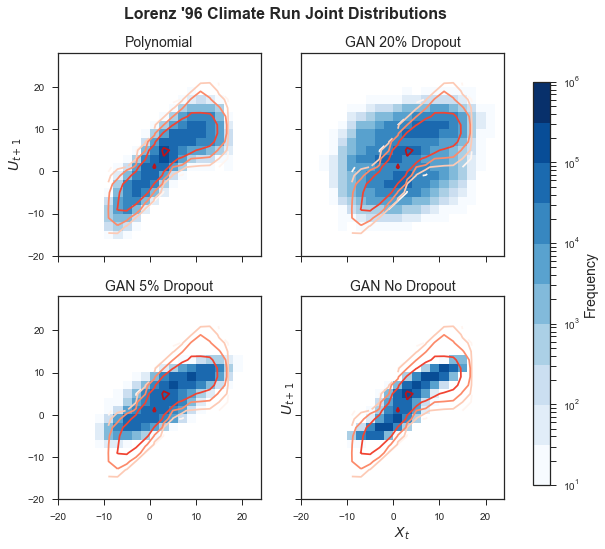

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
x_bins = np.arange(-20, 26, 2)
u_bins = np.arange(-20, 30, 2)
for a, ax in enumerate(axes.ravel()):
    print(a, ax)
    h, xb, yb, ha = ax.hist2d(all_data[models[a]]["x"][:-1, 0].values, all_data[models[a]]["u"][1:, 0].values, bins=(x_bins, u_bins),
              cmin=1, norm=LogNorm(10, 1000000), cmap=plt.get_cmap("Blues", 10))
    ax.contour(0.5 * (x_bins[:-1] + x_bins[1:]), 0.5 * (u_bins[:-1] + u_bins[1:]), true_hist.T, 
               np.array([10, 100, 1000, 10000, 100000, 1000000]),
               norm=LogNorm(10, 1000000), cmap="Reds")
    ax.set_title(long_model_names[a], fontsize=14)
    if a > 2:
        ax.set_xlabel("$X_t$", fontsize=14)
    if a in [0, 3]:
        ax.set_ylabel("$U_{t+1}$", fontsize=14)
fig.subplots_adjust(top=0.9, right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(ha, cax=cbar_ax, )
cbar_ax.set_ylabel("Frequency", fontsize=14)
fig.suptitle("Lorenz '96 Climate Run Joint Distributions", fontsize=16, fontweight="bold", x=0.52, y=0.98)
plt.savefig("l96_climate_joint_hist.png", dpi=200, bbox_inches="tight")

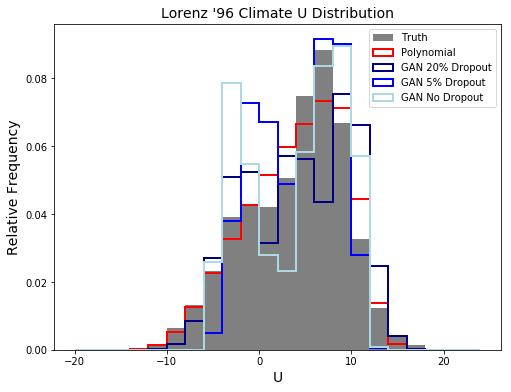

In [94]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
var_names = ["u"]
true_vals = [u_vals[:, 0]]
bin_vals = [x_bins, u_bins]
m_colors = ["red", "navy", "blue", "lightblue"]
for a, ax in enumerate([axes]):
    ax.hist(true_vals[a], color="gray", bins=bin_vals[a], normed=True, label="Truth")
    for m, model in enumerate(models):
        ax.hist(all_data[model][var_names[a]][:, 0].values, histtype="step", 
                color=m_colors[m], bins=bin_vals[a], lw=2, normed=True, label=long_model_names[m])
    ax.set_xlabel(var_names[a].upper(), fontsize=14)
    ax.set_ylabel("Relative Frequency", fontsize=14)
    ax.set_title("Lorenz '96 Climate {0} Distribution".format(var_names[a].upper()), fontsize=14)
    ax.legend()
    #ax.set_yscale("log")
plt.savefig("l96_climate_marginal_hist.png", dpi=200, bbox_inches="tight")

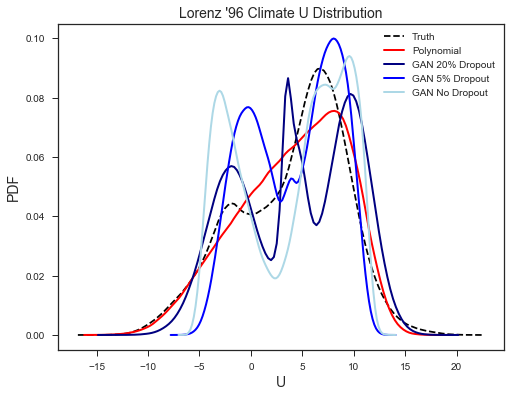

In [71]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
var_names = ["u"]
true_vals = [u_vals[:, 0]]
bin_vals = [x_bins, u_bins]
m_colors = ["red", "navy", "blue", "lightblue"]
for a, ax in enumerate([axes]):
    sns.kdeplot(true_vals[a], color="k", ax=ax, ls="--", gridsize=100, label="Truth")
    for m, model in enumerate(models):
        sns.kdeplot(all_data[model][var_names[a]][:, 0].values, gridsize=100,
                color=m_colors[m], lw=2, ax=ax, label=long_model_names[m])
    ax.set_xlabel(var_names[a].upper(), fontsize=14)
    ax.set_ylabel("PDF", fontsize=14)
    ax.set_title("Lorenz '96 Climate {0} Distribution".format(var_names[a].upper()), fontsize=14)
    ax.legend()
    #ax.set_yscale("log")
plt.savefig("l96_climate_marginal_hist.png", dpi=200, bbox_inches="tight")

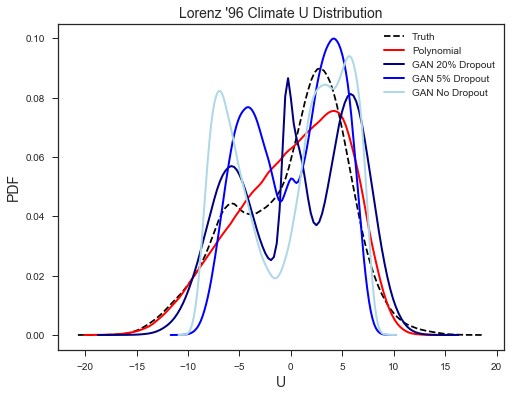

In [74]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
var_names = ["u"]
true_vals = [u_vals[:, 0]]
bin_vals = [x_bins, u_bins]
m_colors = ["red", "navy", "blue", "lightblue"]
for a, ax in enumerate([axes]):
    sns.kdeplot(true_vals[a] - y_scaling_values.loc[0, "mean"], color="k", ax=ax, ls="--", gridsize=100, label="Truth")
    for m, model in enumerate(models):
        sns.kdeplot(all_data[model][var_names[a]][:, 0].values - y_scaling_values.loc[0, "mean"], gridsize=100,
                color=m_colors[m], lw=2, ax=ax, label=long_model_names[m])
    ax.set_xlabel(var_names[a].upper(), fontsize=14)
    ax.set_ylabel("PDF", fontsize=14)
    ax.set_title("Lorenz '96 Climate {0} Distribution".format(var_names[a].upper()), fontsize=14)
    ax.legend()
    #ax.set_yscale("log")
plt.savefig("l96_climate_marginal_hist.png", dpi=200, bbox_inches="tight")

In [78]:
lags = np.arange(1, 200)
x_lag_corrs = np.zeros((len(models), lags.size))
true_lag_corrs = np.zeros(lags.size)
for m, model in enumerate(models):
    print(model)
    model_x_values = all_data[model]["x"][:, 0].values
    for l, lag in enumerate(lags):
        x_lag_corrs[m, l] = np.corrcoef(model_x_values[:-lag], 
                                        model_x_values[lag:])[0, 1]
for l, lag in enumerate(lags):
    true_lag_corrs[l] = np.corrcoef(x_vals[:-lag], 
                                    x_vals[lag:])[0, 1]

poly_add_climate
gan_20_climate
gan_05_climate
gan_00_climate


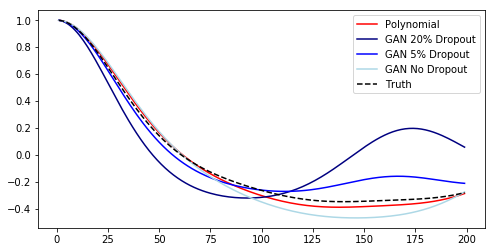

In [80]:
plt.figure(figsize=(8, 4))
for m, model in enumerate(models):
    plt.plot(lags, x_lag_corrs[m], color=m_colors[m], label=long_model_names[m])
plt.plot(lags, true_lag_corrs, "k--", label="Truth")
plt.legend()


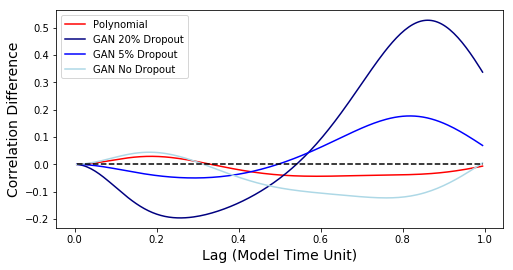

In [103]:
plt.figure(figsize=(8, 4))
for m, model in enumerate(models):
    plt.plot(lags / 200, x_lag_corrs[m] - true_lag_corrs, color=m_colors[m], label=long_model_names[m])
plt.legend()
plt.plot(lags / 200, np.zeros(lags.shape), 'k--')
plt.xlabel("Lag (Model Time Unit)", fontsize=14)
plt.ylabel("Correlation Difference", fontsize=14)

In [88]:
np.corrcoef(x_vals[:-1], x_vals[1:])

array([[ 1.       ,  0.9993089],
       [ 0.9993089,  1.       ]])

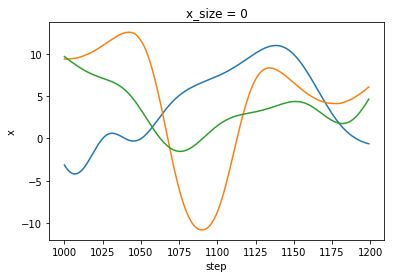

In [8]:
all_data["gan_00_climate"]["x"][1000:1200,0].plot()
all_data["gan_20_climate"]["x"][1000:1200,0].plot()
all_data["poly_add_climate"]["x"][1000:1200,0].plot()

In [ ]:
gan_loss = pd.read_csv("/Users/dgagne/gd/Lorenz_GAN_docs/exp_20_dense/gan_loss_history_0000.csv", index_col="Time")

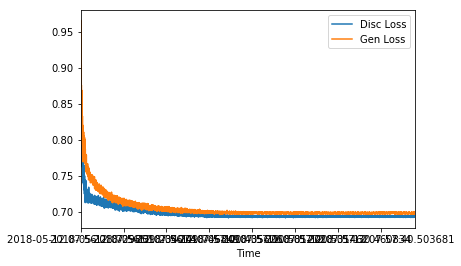

In [25]:
gan_loss[["Disc Loss", "Gen Loss"]].plot()

In [68]:
d_input = K.placeholder(shape=(16, ))
d_func = K.function([d_input, K.learning_phase()], [Dropout(0.5)(d_input)])

In [70]:
d_func([np.ones((16)), 1])

[array([ 0.,  0.,  2.,  2.,  2.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  0.,
         2.,  2.,  2.], dtype=float32)]

In [3]:
train_data = pd.read_csv("/Users/dgagne/gd/Lorenz_GAN_docs/exp_20_dense/lorenz_combined_output.csv")

In [106]:
train_data.columns["X_t"]

Index(['x_index', 'step', 'time', 'u_scale', 'X_t', 'Uy_t', 'Uy_t+1', 'Ux_t',
       'Ux_t+1', 'Y_t_0', 'Y_t_1', 'Y_t_2', 'Y_t_3', 'Y_t_4', 'Y_t_5', 'Y_t_6',
       'Y_t_7', 'Y_t_8', 'Y_t_9', 'Y_t_10', 'Y_t_11', 'Y_t_12', 'Y_t_13',
       'Y_t_14', 'Y_t_15', 'Y_t_16', 'Y_t_17', 'Y_t_18', 'Y_t_19', 'Y_t_20',
       'Y_t_21', 'Y_t_22', 'Y_t_23', 'Y_t_24', 'Y_t_25', 'Y_t_26', 'Y_t_27',
       'Y_t_28', 'Y_t_29', 'Y_t_30', 'Y_t_31', 'Y_t+1_0', 'Y_t+1_1', 'Y_t+1_2',
       'Y_t+1_3', 'Y_t+1_4', 'Y_t+1_5', 'Y_t+1_6', 'Y_t+1_7', 'Y_t+1_8',
       'Y_t+1_9', 'Y_t+1_10', 'Y_t+1_11', 'Y_t+1_12', 'Y_t+1_13', 'Y_t+1_14',
       'Y_t+1_15', 'Y_t+1_16', 'Y_t+1_17', 'Y_t+1_18', 'Y_t+1_19', 'Y_t+1_20',
       'Y_t+1_21', 'Y_t+1_22', 'Y_t+1_23', 'Y_t+1_24', 'Y_t+1_25', 'Y_t+1_26',
       'Y_t+1_27', 'Y_t+1_28', 'Y_t+1_29', 'Y_t+1_30', 'Y_t+1_31'],
      dtype='object')

In [12]:
del gen_models[:]

In [4]:
epochs = np.arange(1, 31)
gen_models = []
for epoch in epochs:
    print(epoch)
    gen_models.append(load_model("/Users/dgagne/lorenz_gan/exp_travis/gan_generator_0000_epoch_{0:04d}.h5".format(epoch)))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [5]:
x_scaling_values = pd.read_csv("/Users/dgagne/gd/Lorenz_GAN_docs/exp_20_dense/gan_X_scaling_values_0005.csv",
                              index_col="Channel")
y_scaling_values = pd.read_csv("/Users/dgagne/gd/Lorenz_GAN_docs/exp_20_dense/gan_Y_scaling_values_0005.csv",
                              index_col="Channel")

In [6]:
preds = []
for g, gen_model in enumerate(gen_models):
    pred_func = K.function(gen_model.input + [K.learning_phase()], [gen_model.output])
    preds.append(pred_func([(train_data[["X_t", "Ux_t"]] 
                             - x_scaling_values["mean"].values) / x_scaling_values["std"].values, 
                            np.random.normal(size=(train_data.shape[0], 1)), 1]))
    

In [7]:
sns.set_style("ticks")

In [8]:
def plot_kde(epoch):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(train_data["Ux_t+1"], color="r", ls="--", label="Truth")
    sns.kdeplot(preds[epoch - 1][0].ravel() * y_scaling_values.loc[0, "std"] + y_scaling_values.loc[0, "mean"], 
                color="k", label="GAN Epoch {0:02d}".format(epoch))
    plt.xlim(-15, 20)
    plt.ylim(0, 0.2)
    plt.legend()
    plt.title("GAN U Distribution Epoch {0:02d}".format(epoch), fontsize=14)
    plt.xlabel("Subgrid Forcing U", fontsize=14)
    plt.ylabel("PDF", fontsize=14)
interact(plot_kde, epoch=IntSlider(value=1, min=1, max=30))
    

interactive(children=(IntSlider(value=1, description='epoch', max=30, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_kde(epoch)>

In [12]:
for e in range(1, 31):
    plot_kde(e)
    plt.savefig("gan_dist/gan_u_dist_e_{0:02d}.png".format(e), dpi=200, bbox_inches="tight")
    plt.close()

In [10]:
from statsmodels.nonparametric.kde import KDEUnivariate

In [11]:
kde_true = KDEUnivariate(train_data["Ux_t+1"])
kde_true.fit(gridsize=100)
u_points = np.arange(-15, 20.5, 0.5)
true_pdf = kde_true.evaluate(u_points)
def hellinger(a, b):
    return np.sqrt(np.sum((np.sqrt(a) - np.sqrt(b)) ** 2)) / np.sqrt(2)

def plot_kde_diff(epoch):
    kde_epoch = KDEUnivariate(preds[epoch - 1][0].ravel().astype(float)* y_scaling_values.loc[0, "std"] + y_scaling_values.loc[0, "mean"])
    kde_epoch.fit(gridsize=100)
    epoch_pdf = kde_epoch.evaluate(u_points)
    plt.plot(u_points, epoch_pdf)
    plt.plot(u_points, true_pdf)
    plt.title(hellinger(epoch_pdf, true_pdf))
interact(plot_kde_diff, epoch=IntSlider(1, 1, 30))

interactive(children=(IntSlider(value=1, description='epoch', max=30, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_kde_diff(epoch)>

In [41]:
epoch = 10
kde_epoch = KDEUnivariate(preds[epoch - 1][0].ravel().astype(float) * y_scaling_values.loc[0, "std"] + y_scaling_values.loc[0, "mean"])
kde_epoch.fit(gridsize=100)
epoch_vals = kde_epoch.evaluate(u_points)

In [46]:
def hellinger(a, b):
    return np.sqrt(np.sum(np.sqrt(a) + np.sqrt(b))) / np.sqrt(2)
hellinger(true_pdf, epoch_vals)

3.1158748671508039

In [4]:
storm_gen = load_model("/d1/dgagne/spatial_storm_results_20171220/logistic_gan_0_generator.h5", compile=False)

In [11]:
storm_gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              266240    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         819328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
__________

In [34]:
rand_vec = np.random.normal(size=(1, 64))
out = storm_gen.predict(rand_vec)

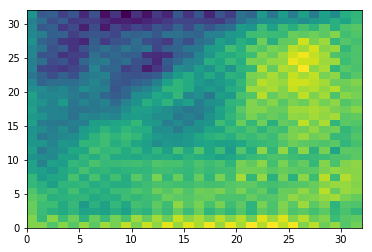

In [35]:
plt.pcolormesh(out[0, :, :, 14])

In [31]:
output_image = K.placeholder(storm_gen.output.shape)
loss = K.mean((storm_gen.output - output_image) ** 2)
back_grad = K.gradients(loss, [storm_gen.input])
back_func = K.function([output_image, storm_gen.input, K.learning_phase()], back_grad)

In [38]:
grad_vec = back_func([out, rand_vec, 0])[0]

In [39]:
grad_vec - rand_vec

array([[ 0.06119015, -1.45144983, -1.4650528 ,  0.72389829,  0.57435266,
         1.20375962,  0.11892127,  0.98309904, -0.66790656, -0.6346919 ,
         1.04753316,  1.35391103, -1.08669851,  0.67630246,  2.5168406 ,
        -0.5747017 , -0.16625034,  1.35881489, -1.08704259,  0.77239309,
        -0.64923575,  0.27184219, -1.22555029,  0.85657667,  1.69944132,
        -0.76888336,  2.14130663, -0.37890832, -1.11473635, -0.27178834,
         1.75480905, -0.95700945,  0.85619659, -0.32525141,  2.39589236,
        -0.48207776, -0.26152864, -0.49082541, -1.28558897, -0.90093777,
         0.6177793 , -0.92731069,  1.66803703,  0.46372245,  1.81123237,
         0.73409826,  0.07980821,  2.39512129, -1.62304525,  1.07564616,
         0.22523666,  0.66659512, -1.45823704, -0.14974203,  1.35642919,
        -0.28984689,  0.16560961, -0.60247137,  0.04683801,  0.55171271,
         0.10792367, -0.21464413,  0.87038535,  1.28929214]])